# Predicting Tumor Diagnosis
## Mohammad Shahidul Kader, Lindsey Rohrer, Dylan Dunlap

In [230]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. I like it most for plot
%matplotlib inline
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import GridSearchCV# for tuning parameter
from sklearn.ensemble import RandomForestClassifier # for random forest classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm # for Support Vector Machine
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score


In [231]:
cancer = pd.read_csv('breastCancer.csv', na_values='?')
print(cancer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [232]:
cancer['diagnosis']=cancer['diagnosis'].map({'M':1,'B':0})

cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [233]:
cancer.drop("id",axis=1,inplace=True)
cancer.drop("Unnamed: 32",axis=1,inplace=True)

features_mean= list(cancer.columns[1:11])
features_se= list(cancer.columns[11:20])
features_worst=list(cancer.columns[21:31])

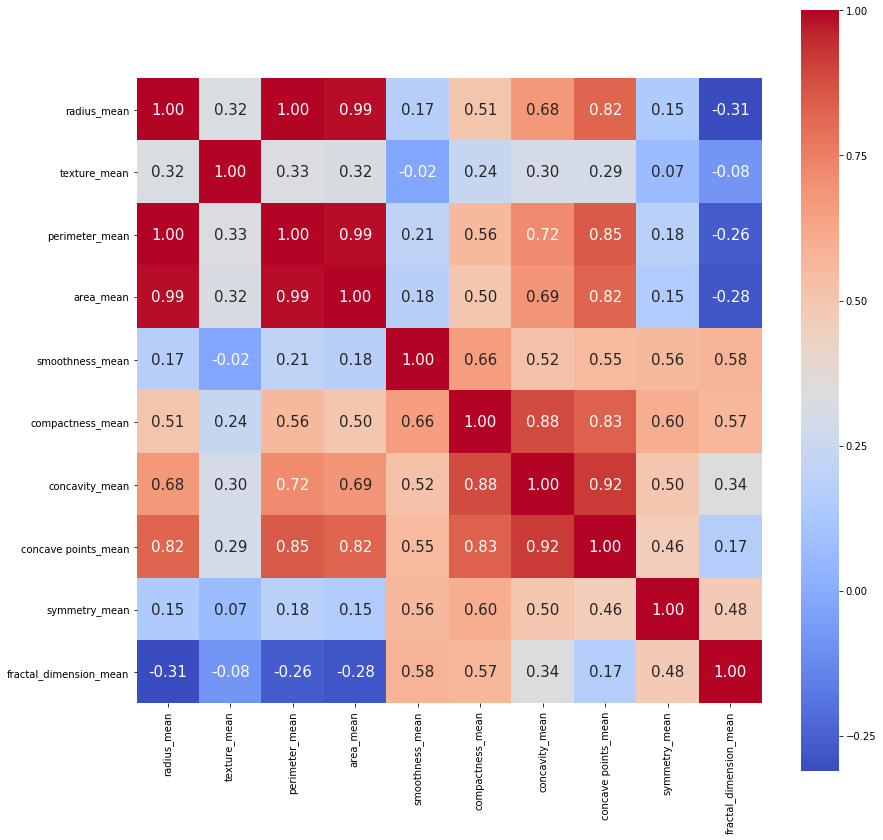

In [234]:
corr = cancer[features_mean].corr() # .corr is used for find corelation
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features_mean, yticklabels= features_mean,
           cmap= 'coolwarm')

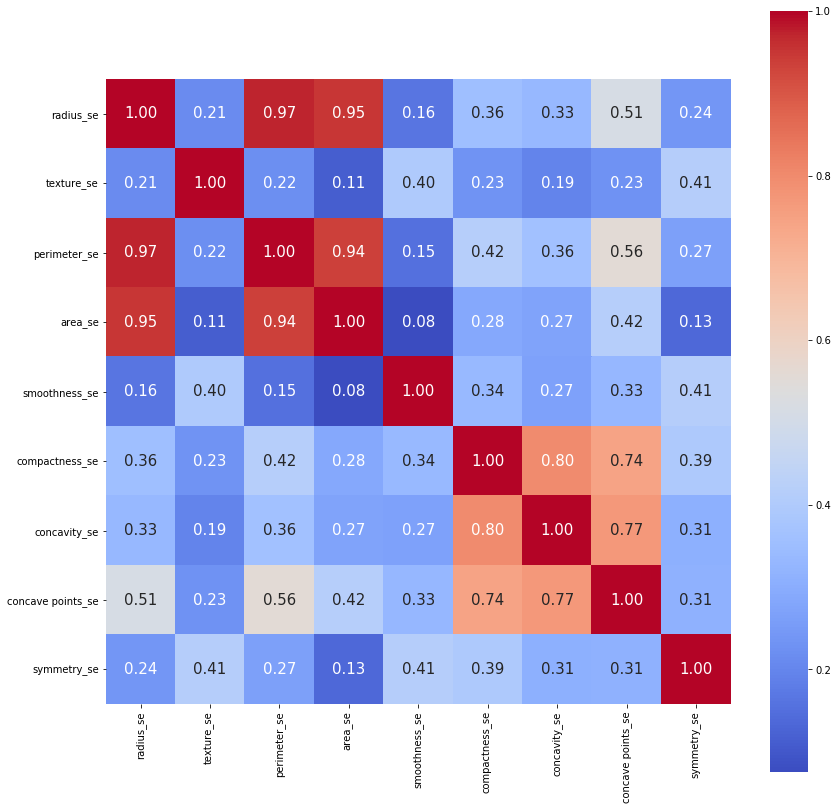

In [235]:
corr = cancer[features_se].corr() # .corr is used for find corelation
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features_se, yticklabels= features_se,
           cmap= 'coolwarm')

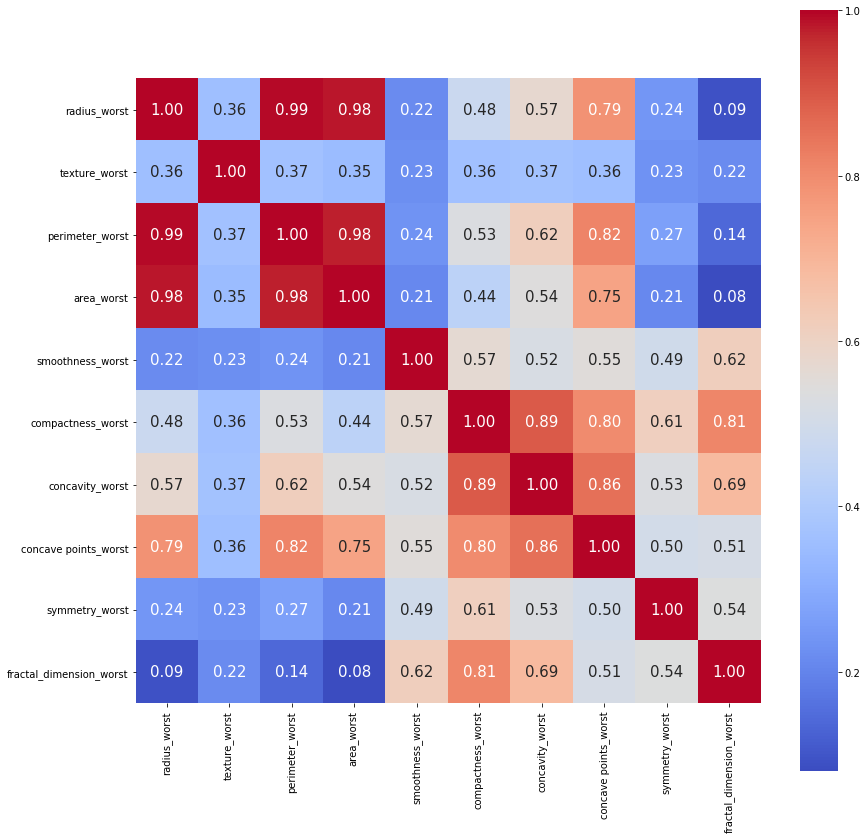

In [236]:
corr = cancer[features_worst].corr() # .corr is used for find corelation
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features_worst, yticklabels= features_worst,
           cmap= 'coolwarm')

### Select features on the basis of correlation

In [237]:
def correlation(dataset, threshold):
    """The function measures correlatino among independent variables and
    selects variables on the basis of provided threshold."""
    new_df = dataset.copy()
    new_df = new_df.drop(columns='diagnosis', axis=1)
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = new_df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= abs(threshold)) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in new_df.columns:
                    del new_df[colname] # deleting the column from the dataset
    features = new_df.columns.tolist()

    return features

In [238]:
features = correlation(cancer, 0.4)
print(features)

['radius_mean', 'texture_mean', 'smoothness_mean', 'texture_se', 'smoothness_se', 'compactness_se', 'symmetry_worst']


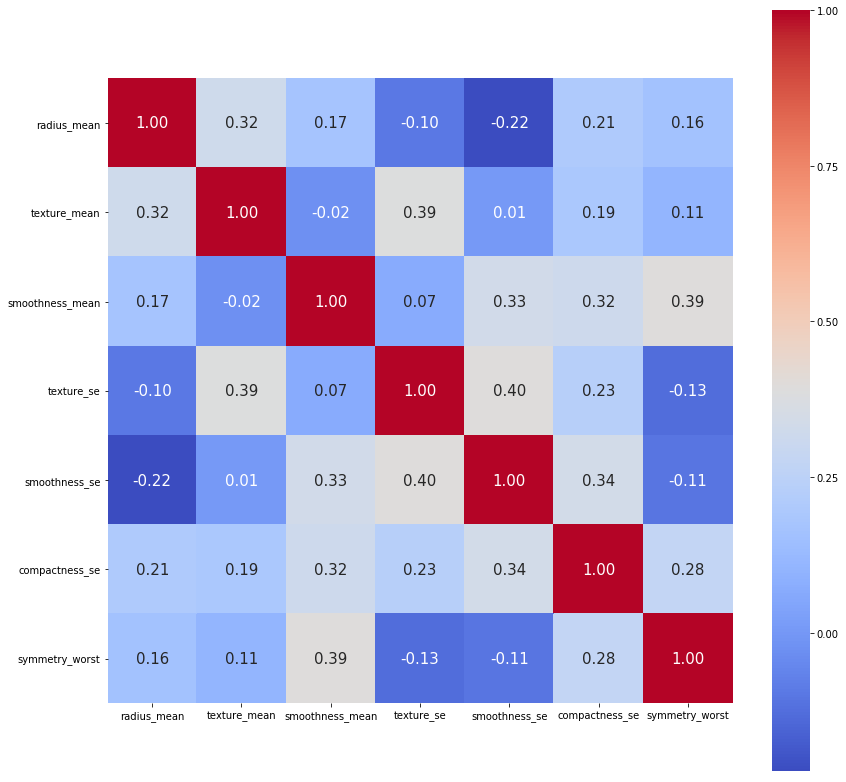

In [239]:
corr = cancer[features].corr() # .corr is used for find corelation
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features,
           cmap= 'coolwarm')

# Create Training and Testing data 

In [240]:
# define the X and y variables
X = cancer[features]
y = cancer["diagnosis"]

# Instruction: split the dataset to training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)

print("The length of the train dataset is: ", len(X_train))
print("The length of the test dataset is: ", len(X_test))

The length of the train dataset is:  398
The length of the test dataset is:  171


# 1. Logistic Regression

In [241]:
lr=LogisticRegression()
# classification_model(model,traindf,predictor_var,outcome_var)
lr.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [242]:
lr_predictions = lr.predict(X_test)

In [243]:
# Confusion matrix
print(confusion_matrix(y_test, lr_predictions))

[[110   6]
 [ 12  43]]


In [244]:
# Accuracy score and classification report
print("Logistic regression accuracy score is: ", accuracy_score(y_test, lr_predictions))
print("\nClassification report:\n", classification_report(y_test, lr_predictions))

Logistic regression accuracy score is:  0.8947368421052632

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       116
           1       0.88      0.78      0.83        55

   micro avg       0.89      0.89      0.89       171
   macro avg       0.89      0.87      0.88       171
weighted avg       0.89      0.89      0.89       171



AUC= 0.9556426332288401


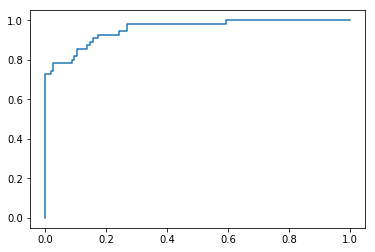

In [245]:
y_pred_prob = lr.predict_proba(X_test)[:,1]

print("AUC=", roc_auc_score(y_test, y_pred_prob))


# plot ROC
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)

In [246]:
import statsmodels.formula.api as sm
logit = sm.Logit(y_train, X_train)
result = logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.503489
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            6
Date:                Wed, 24 Apr 2019   Pseudo R-squ.:                  0.2493
Time:                        17:40:49   Log-Likelihood:                -200.39
converged:                       True   LL-Null:                       -266.94
                                        LLR p-value:                 2.851e-26
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
radius_mean         0.3293      0.046      7.102      0.000       0.238       0.420
texture_mean       -0.0242      0.032     -0.768      0.442      -0.086       0.038
smoothness_mean   -44.6078     10.431     -4.277      0.000     -65.051     -24.164
texture_se         -0.5763      0.323     -1.783      0.075      -1.210       0.057
smoothness_se    -144.8544     56.870     -2.547      0.011    -256.317     -33.392
compactness_se     49.2973      9.408      5.240      0.000      30.858      67.736
symmetry_worst      0.3951      2.367      0.167      0.867      -4.244       5.034
===================================================================================
"""

# 2. Naive Bayes

In [247]:
GNB = GaussianNB() #creating the naive bayes classifier object
GNB.fit(X_train, y_train)      #fitting the classifier to the training data points x providing         
                   ## their already known classes in the list y which is of same  
                   #length as X and every element is the class of the   
                   #corresponding element (datapoint) in x                                                             

GaussianNB(priors=None, var_smoothing=1e-09)

In [248]:
GNB_predictions = GNB.predict(X_test)

In [249]:
# Confusion matrix
print(confusion_matrix(y_test, GNB_predictions))

[[109   7]
 [  6  49]]


In [250]:
# Accuracy score and classification report
print("Naive Bayes accuracy score is: ", accuracy_score(y_test, GNB_predictions))
print("\nClassification report:\n", classification_report(y_test, GNB_predictions))

Naive Bayes accuracy score is:  0.9239766081871345

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94       116
           1       0.88      0.89      0.88        55

   micro avg       0.92      0.92      0.92       171
   macro avg       0.91      0.92      0.91       171
weighted avg       0.92      0.92      0.92       171



# 3. Decision Tree

In [251]:
#dtree = DecisionTreeClassifier(max_depth=3)
#dtree.fit(X_train, y_train)

In [252]:
#dtree_predictions = dtree.predict(X_test)

In [253]:
# Confusion matrix
#print(confusion_matrix(y_test, dtree_predictions))

In [258]:
for i in range(1,10):
    dtree = DecisionTreeClassifier(max_depth=i)
    dtree.fit(X_train, y_train)
    dtree_predictions = dtree.predict(X_test)
    accuracy = accuracy_score(y_test, dtree_predictions)
    print("For max depth = %s, the decision tree accuracy score is: %s" %(i, accuracy))

For max depth = 1, the decision tree accuracy score is: 0.8947368421052632
For max depth = 2, the decision tree accuracy score is: 0.9122807017543859
For max depth = 3, the decision tree accuracy score is: 0.9122807017543859
For max depth = 4, the decision tree accuracy score is: 0.935672514619883
For max depth = 5, the decision tree accuracy score is: 0.9415204678362573
For max depth = 6, the decision tree accuracy score is: 0.935672514619883
For max depth = 7, the decision tree accuracy score is: 0.9181286549707602
For max depth = 8, the decision tree accuracy score is: 0.9415204678362573
For max depth = 9, the decision tree accuracy score is: 0.9239766081871345


In [265]:
dtree = DecisionTreeClassifier(max_depth=5)
dtree.fit(X_train, y_train)
dtree_predictions = dtree.predict(X_test)
accuracy = accuracy_score(y_test, dtree_predictions)

In [266]:
# Accuracy score and classification report
print("Decision tree accuracy score is: ", accuracy_score(y_test, dtree_predictions))
print("\nClassification report:\n", classification_report(y_test, dtree_predictions))

Decision tree accuracy score is:  0.9415204678362573

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       116
           1       0.89      0.93      0.91        55

   micro avg       0.94      0.94      0.94       171
   macro avg       0.93      0.94      0.93       171
weighted avg       0.94      0.94      0.94       171



In [257]:
print(confusion_matrix(y_test, dtree_predictions))

[[110   6]
 [  3  52]]


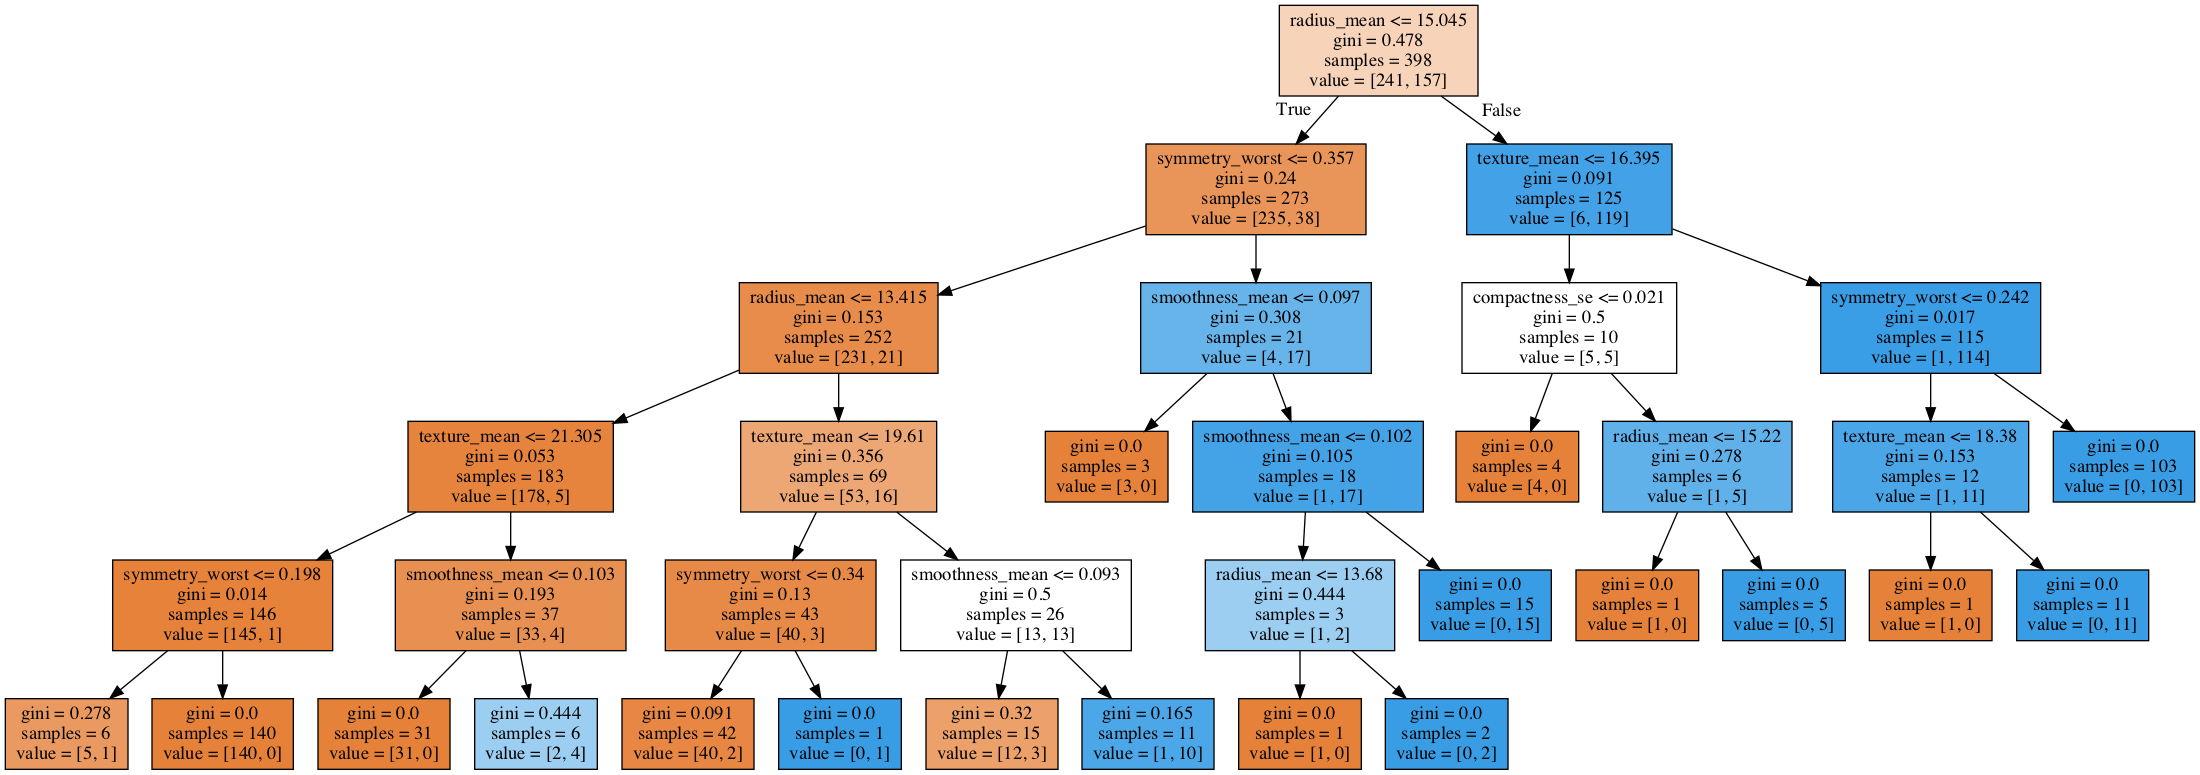

In [267]:
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)


graph = print_tree(dtree, features=features)
graph.write_png("tree.png")
Image(graph.create_png())

# 4. Random Forest

In [187]:
# Using all features
# define the X and y variables
#X = cancer.drop(columns='diagnosis')
#y = cancer["diagnosis"]

# Instruction: split the dataset to training and test
#X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.30)


In [188]:
X_train.head()

,radius_mean,texture_mean,smoothness_mean,texture_se,smoothness_se,compactness_se,symmetry_worst
491,17.85,13.23,0.07838,1.0460,0.004369,0.008274,0.1783
18,19.81,22.15,0.09831,1.0170,0.006494,0.018930,0.2768
392,15.49,19.97,0.11600,1.3310,0.007269,0.029280,0.3187
73,13.80,15.79,0.10070,0.6205,0.004717,0.020650,0.2589
393,21.61,22.28,0.11670,0.9209,0.005215,0.037260,0.3828


In [189]:
max_features = X_train.shape[1]

In [190]:
# Play around with the setting for max_features
rfc_scores = []
for i in range(1, max_features+1):
    rf2 = RandomForestClassifier(max_features=i, random_state=13)
    rf2.fit(X_train, y_train)
    pred1 = rf2.predict(X_test)
    accuracy = accuracy_score(y_test, pred1)
    rfc_scores.append(accuracy)
    print("Accuracy for %s feature(s) equals %s" %(i, accuracy))

Accuracy for 1 feature(s) equals 0.9298245614035088
Accuracy for 2 feature(s) equals 0.9239766081871345
Accuracy for 3 feature(s) equals 0.9298245614035088
Accuracy for 4 feature(s) equals 0.9298245614035088
Accuracy for 5 feature(s) equals 0.935672514619883
Accuracy for 6 feature(s) equals 0.9415204678362573
Accuracy for 7 feature(s) equals 0.935672514619883


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 

In [191]:
best_max_features = rfc_scores.index(max(rfc_scores)) + 1
print("Max features with best accuracy: ", best_max_features)

Max features with best accuracy:  6


In [192]:
rfc = RandomForestClassifier(max_features=best_max_features, random_state=13)

In [193]:
rfc.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [194]:
rfc_predictions = rfc.predict(X_test)

In [195]:
# Confusion matrix
print(confusion_matrix(y_test, rfc_predictions))

[[111   5]
 [  5  50]]


In [196]:
# Accuracy score and classification report
print("Random forest accuracy score is: ", accuracy_score(y_test, rfc_predictions))
print("\nClassification report:\n", classification_report(y_test, rfc_predictions))

Random forest accuracy score is:  0.9415204678362573

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       116
           1       0.91      0.91      0.91        55

   micro avg       0.94      0.94      0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



In [197]:
#Create a series with feature importances:
featimp = pd.Series(rfc.feature_importances_, index=X_train.columns.tolist()).sort_values(ascending=False)
print(featimp)

radius_mean        0.661054
symmetry_worst     0.118218
texture_mean       0.085970
smoothness_mean    0.080141
smoothness_se      0.019059
compactness_se     0.018635
texture_se         0.016923
dtype: float64


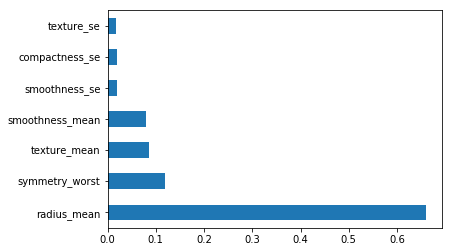

In [198]:

featimp.nlargest(10).plot(kind='barh')

# 5. Support Vector Machines 

In [199]:
svclassifier = svm.SVC(kernel='linear')  

In [200]:
svclassifier.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [201]:
svc_predictions = svclassifier.predict(X_test)

In [202]:
# Confusion matrix
print(confusion_matrix(y_test, svc_predictions))

[[107   9]
 [ 10  45]]


In [203]:
# Accuracy score and classification report
print("SVC accuracy score is: ", accuracy_score(y_test, svc_predictions))
print("\nClassification report:\n", classification_report(y_test, svc_predictions))

SVC accuracy score is:  0.8888888888888888

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       116
           1       0.83      0.82      0.83        55

   micro avg       0.89      0.89      0.89       171
   macro avg       0.87      0.87      0.87       171
weighted avg       0.89      0.89      0.89       171

